In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from matplotlib import rcParams

from IPython.display import display

np.random.seed(42)
pd.options.display.max_columns = None
emp_data = pd.read_csv('../data/interim/emp_data_post_EDA.tsv',sep='\t')

In [2]:
print(emp_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeNumber            1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1470 non-null   int64  
 3   BusinessTravel            1470 non-null   object 
 4   Department                1470 non-null   object 
 5   DistanceFromHome          1470 non-null   int64  
 6   Education                 1470 non-null   int64  
 7   EducationField            1470 non-null   object 
 8   EnvironmentSatisfaction   1470 non-null   int64  
 9   Gender                    1470 non-null   object 
 10  JobInvolvement            1470 non-null   int64  
 11  JobLevel                  1470 non-null   int64  
 12  JobRole                   1470 non-null   object 
 13  JobSatisfaction           1470 non-null   int64  
 14  MaritalS

Part 1: Drop certain columns based on EDA:

-- Drop Stock Option Level because of unintuitive non-linear relationship exhibited in EDA. Attrition rates are higher for the lowest and highest stock option levels, and lower for the middle two levels.  This may be due to confounding factors such as the employee's department (e.g., they may work in a more dynamic talent market where equity compensation and turnover are both more common) or their general performance and marketability (e.g., high performing executives that are in greater demand externally). Therefore I don't see value in including this feature as a predictor, as the real drivers of attrition should lie in other features.

-- Drop Job Level because it is highly correlated with monthly income but less desirable as a predictor since it has discrete values.

In [3]:
#Drop columns
emp_data.drop(columns=['JobLevel','StockOptionLevel'],inplace=True)

Part 2: convert education column values to brief string descriptors to make them categorical and enhance interpretability. Other numeric categoricals are ordinal and will be dealt with in the next part

In [4]:
emp_data.replace({'Education':{1:'<College',2:'College',3:'Bachelor',4:'Master',5:'Doctor'}},inplace=True)

Part 3: encode ordinal categoricals. Based on EDA, certain ordinal categoricals appear to exhibit a linear or near-linear relationship with attrition probability -- these will be left alone -- while others exhibit a materially higher attrition rate for the lowest value but have essentially similar attrition rates for other values -- these will be binary encoded with a 0 for the lowest value and a 1 for all other values.

Performance rating only had two values, so I will transform this column to be 0 for a rating of 3 and 1 for a rating of 4.

In [5]:
#Re-encode the ordinals that can be represented as binary
to_binary = ['EnvironmentSatisfaction','RelationshipSatisfaction','WorkLifeBalance']
for c in to_binary:
    emp_data[c]=(emp_data[c]>min(emp_data[c])).astype('int')

In [6]:
#Re-map performance rating from 3 and 4 to 0 and 1
emp_data['PerformanceRating']=emp_data['PerformanceRating']-3

Part 4: dummy encode the nominal categoricals, which consist of the string/object columns and the TrainingTimesLastYear column, which we will first bin and convert to strings. Aside from those with no training, those who received training twice or four times also had materially higher attrition rates for some reason.

In [7]:
#Bin TrainingTimesLastYear
emp_data.replace({'TrainingTimesLastYear':{0:'None',1:'1/3/5/6',2:'Twice',3:'1/3/5/6',4:'Four Times',5:'1/3/5/6',6:'1/3/5/6'}},inplace=True)

In [8]:
nominals=emp_data.select_dtypes(include='object').columns
print(nominals)

Index(['BusinessTravel', 'Department', 'Education', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime', 'TrainingTimesLastYear'],
      dtype='object')


In [9]:
dummies = pd.get_dummies(emp_data[nominals],drop_first=True)
emp_data = pd.concat([emp_data.drop(columns=nominals),dummies],axis=1)
emp_data.set_index(keys='EmployeeNumber',inplace=True)
print(emp_data.head())
print(emp_data.shape)

                Age  Attrition  DistanceFromHome  EnvironmentSatisfaction  \
EmployeeNumber                                                              
1                41          1                 1                        1   
2                49          0                 8                        1   
4                37          1                 2                        1   
5                33          0                 3                        1   
7                27          0                 2                        0   

                JobInvolvement  JobSatisfaction  MonthlyIncome  \
EmployeeNumber                                                   
1                            3                4           5993   
2                            2                2           5130   
4                            2                3           2090   
5                            3                3           2909   
7                            3                2           3468  

Part 5: Train test split

In [10]:
X = emp_data.drop(columns='Attrition')
y = emp_data['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [11]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1102, 45) (368, 45) (1102,) (368,)


Part 6: transform continuous numerical variables with PowerTransformer based on the distributions as visualized during EDA (all long-tailed).

In [12]:
power_columns = ['Age','MonthlyIncome','DistanceFromHome','NumCompaniesWorked','PercentSalaryHike','TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager','RatioToMedianPay']
for c in power_columns:
    power_trans = PowerTransformer()
    power_trans.fit(X_train[[c]])
    X_train.loc[:,c] = power_trans.transform(X_train[[c]])
    X_test.loc[:,c] = power_trans.transform(X_test[[c]])

In [13]:
# MonthlyIncome in a prior version yielded a divide by zero runtime warning when applying PowerTransformer. Here's
# the workaround suggested by user ogrisel in https://github.com/scikit-learn/scikit-learn/issues/14959
# in case needed again in the future. But, would need some updates to variable names
#SS = StandardScaler(with_std=False)
#emp_data['MonthlyIncome']=SS.fit_transform(emp_data[['MonthlyIncome']])
#power_trans = PowerTransformer()
#emp_data['MonthlyIncome']=power_trans.fit_transform(emp_data[['MonthlyIncome']])

Confirm the transformations worked

In [14]:
#For visualization purposes only, to confirm the transformations worked, concatenate X_train and X_test
X_transformed_combined = pd.concat([X_train,X_test])

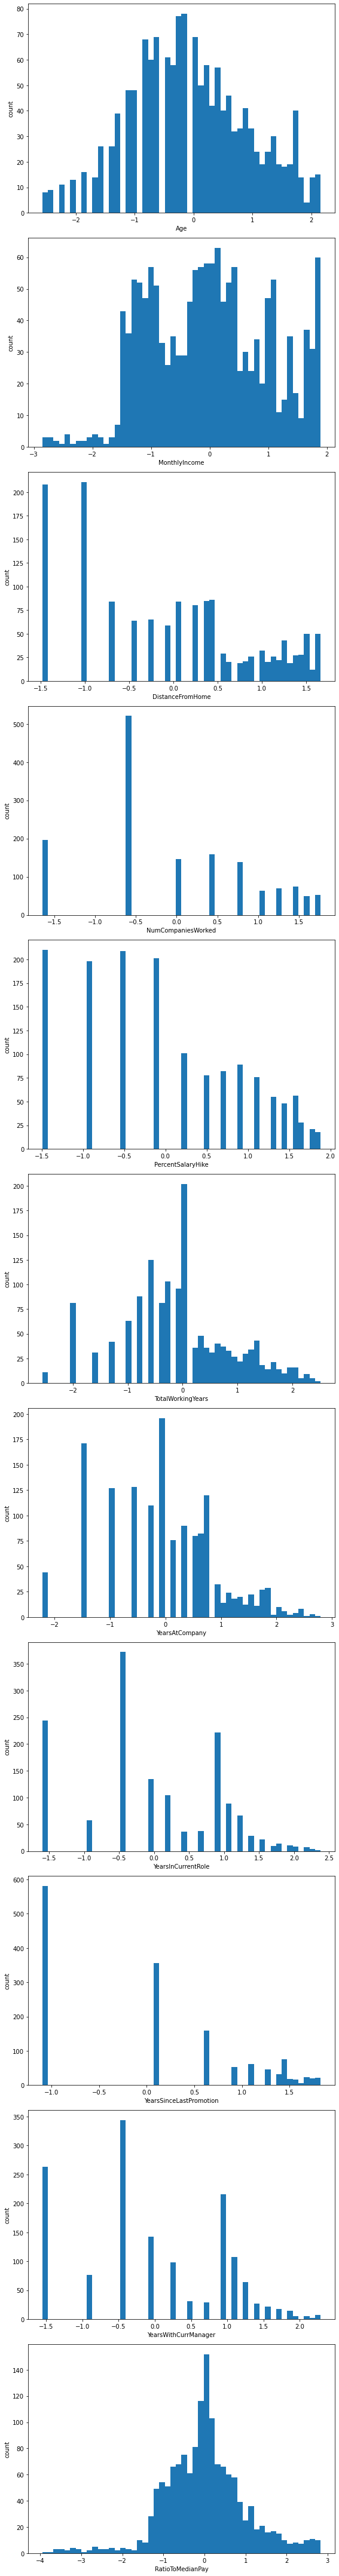

In [15]:
#Create subplots
nums = power_columns
#nums = list(power_columns)+['MonthlyIncome']
fig, axes = plt.subplots(len(nums),1,figsize=(8,60))
for i in range(len(nums)):
    axes[i].hist(X_transformed_combined[nums[i]],bins=50)
    axes[i].set_xlabel(nums[i])
    axes[i].set_ylabel('count')
fig.tight_layout()

Part 7: look at correlation heatmap of preprocessed dataset

In [16]:
y_combined = pd.concat([y_train,y_test])
emp_data_transformed_combined = pd.concat([X_transformed_combined,y_combined],axis=1)

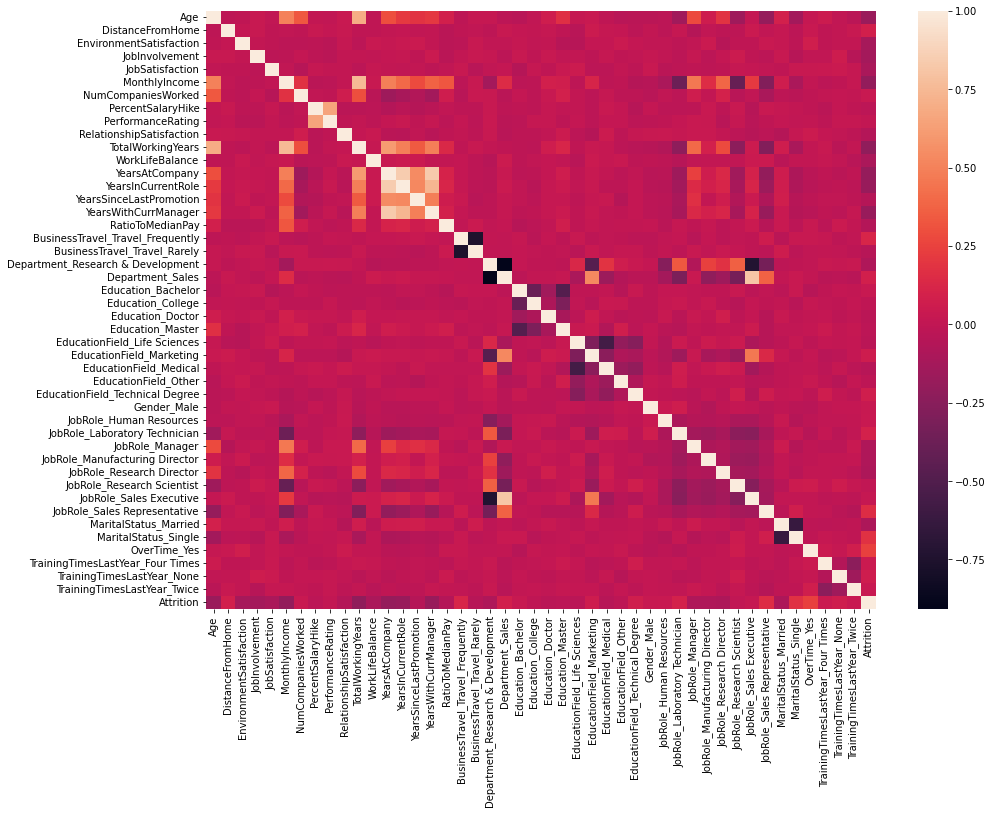

In [17]:
rcParams['figure.figsize'] = 15,11
_ = sns.heatmap(emp_data_transformed_combined.corr(),xticklabels=True,yticklabels=True)

In [18]:
#Double check range of values for each column
print(emp_data_transformed_combined.describe(include='all'))

               Age  DistanceFromHome  EnvironmentSatisfaction  JobInvolvement  \
count  1470.000000       1470.000000              1470.000000     1470.000000   
mean      0.000232         -0.012204                 0.806803        2.729932   
std       0.997859          0.990705                 0.394941        0.711561   
min      -2.571384         -1.482120                 0.000000        1.000000   
25%      -0.721226         -1.033021                 1.000000        2.000000   
50%      -0.005938          0.084218                 1.000000        3.000000   
75%       0.719938          0.823841                 1.000000        3.000000   
max       2.160029          1.661435                 1.000000        4.000000   

       JobSatisfaction  MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  \
count      1470.000000    1470.000000         1470.000000        1470.000000   
mean          2.728571      -0.009186            0.001781          -0.003135   
std           1.102846       1

Part 8: export

In [19]:
X_train.to_csv('../data/processed/X_train.tsv',sep='\t')
X_test.to_csv('../data/processed/X_test.tsv',sep='\t')
y_train.to_csv('../data/processed/y_train.tsv',sep='\t')
y_test.to_csv('../data/processed/y_test.tsv',sep='\t')